# Multi Level Perceptron Model for Given Dataset

## Created by Sean, Sushmita, Vatsal

### Libraries Used :-

In [1]:
import re
import csv
import pandas as pd
import numpy as np
import math
import seaborn as sns

### Function to read both input files to create Training Set, Validation Set, Test Set

In [2]:
def read_input_file(file_name,k):

    feature_vectors = []
    file = open(file_name,'r')

    for line in file:
        vectors = []
        data = re.split(r'[()\s]\s*', line)
        while '' in data:
            data.remove('')

        for item in data:
            vectors.append(int(item))
        feature_vectors.append(vectors)
    if k==1:
        with open("input.csv","w+") as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(feature_vectors)
    else:
        with open("input_2.csv","w+") as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(feature_vectors)        
read_input_file('ClassifiedSetData.txt',1)
read_input_file('TestSetData.txt',2)

### Class for creating MLP
#### Functions :-
<ol>
    <li>init - To initialize required data</li>
    <li>split_data - Splits Data into train, validate and test</li>
    <li>multiplication_between_layers - calculates total input to a perceptron node by $\sum_{i=1}^{n} x_i*w_i$</li>
    <li>merge_data - Merge train and validate sets</li>
    <li>logistic - Activation Function</li>
    <li>forward_propagation - to classify based on inputs</li>
    <li>backward_propagation - to Update Weight as per the result</li>
    <li>accuracy - calculates accuracy of the model</li>
    <li>confusion_matrix - Generates Confusion Matrix</li>
    <li>confusion_matrix_create - preps matrix for beautiful display</li>
</ol>

In [3]:
class MLP:
    def __init__(self):
        self.number_of_nodes=10
        self.max_feature_value=96
        self.num_output_nodes=8
        self.True_Positive=[0]*8
        self.True_Negative=[0]*8
        self.False_Positive=[0]*8
        self.False_Negative=[0]*8
        
    def split_data(self):
        self.df=pd.read_csv('input.csv',header=None)
        self.df1=pd.read_csv('input_2.csv',header=None)
        self.df=self.df.rename({0:'ID',1:'Feature_1',2:'Feature_2',3:'Feature_3',4:'Feature_4',5:'Feature_5',6:'Feature_6',7:'Feature_7',8:'Feature_8',9:'Feature_9',10:'Feature_10',11:'Output'}, axis=1)
        self.df1=self.df1.rename({0:'ID',1:'Feature_1',2:'Feature_2',3:'Feature_3',4:'Feature_4',5:'Feature_5',6:'Feature_6',7:'Feature_7',8:'Feature_8',9:'Feature_9',10:'Feature_10',11:'Output'}, axis=1)
        self.train_data, self.validate_data, self.test_data = np.split(self.df.sample(frac=1,random_state=42), [int(.6*len(self.df)), int(.8*len(self.df))])
    def multiplication_between_layers(self,weights, inputs):
        total=0
        for i in range(len(weights)):
            total += (inputs[i] * weights[i])
        return total   
    def merge_data(self):
        frames = [self.train_data,self.validate_data]
        self.train_data=pd.concat(frames) 
    def logistic(self, x):
        return 1 / ( 1 + math.exp(-x))
    
    def normalize_array(self, features,normalize_value):
        normalized_array=[]
        for i in features:
            normalized_array.append(i/normalize_value)
        return normalized_array
    
    def initialize_weight(self,x_dim,y_dim):
        return np.random.randn(x_dim,y_dim)*np.sqrt(1/y_dim)
    
    def set_weights(self,Wh1,Wh2):
        print("Initial Weight :")
        self.Wh1=Wh1
        print("Hidden Layer Weight = ",self.Wh1)
        self.Wh2=Wh2
        print("Output Layer Weight = ",self.Wh2)
        
    def forward_propagation(self,training_data):
            

        self.hidden_layer = []
        for i in range(self.number_of_nodes):
            self.hidden_layer.append(self.logistic(self.multiplication_between_layers(self.Wh1[i], training_data)))

        self.output_layer = []
    
        for i in range(self.num_output_nodes):
            self.output_layer.append(self.logistic(self.multiplication_between_layers(self.Wh2[i], self.hidden_layer)))
        return self.hidden_layer, self.output_layer
 
    def back_propagation(self,learning_rate, min_accuracy):
        epochs = 0
        while self.accuracy(self.train_data) < min_accuracy:
            epochs += 1
            for value in self.train_data.values:
                training_vector = self.normalize_array(list(value)[1:11], self.max_feature_value)
                self.forward_propagation(training_vector)
   
                error_1= [] 
                for j in range(self.num_output_nodes):
                    p = self.output_layer[j]
                    learning_rate = 0.3
                    if j == list(value)[-1]:
                        learning_rate = 0.7
                    error_1.append(p * (1 - p) * (learning_rate - p))
  
                error_2 = [] 
                for j in range(self.number_of_nodes):
                    hidden_layer_input = self.hidden_layer[j]
                    output_with_error = self.multiplication_between_layers(self.Wh2[:,j], error_1)
                    error_2.append(hidden_layer_input* (1 - hidden_layer_input) * output_with_error)

                for j in range(self.number_of_nodes):
                    for i in range(self.num_output_nodes):
                        self.Wh2[i][j] = self.Wh2[i][j] + learning_rate * error_1[i] * self.hidden_layer[j]
                    for k in range(self.number_of_nodes):
                        self.Wh1[j][k] = self.Wh1[j][k]   + learning_rate * error_2[j] * training_vector[k]
            #print('finish',self.s) # Vatsal this for just testing 
                 
        return epochs
    def accuracy(self, input_data):
        correct = 0
        for data in input_data.values:
            hidden_layer, output_layer = self.forward_propagation(self.normalize_array(list(data)[1:11], self.max_feature_value))
            if (np.argmax(output_layer) == list(data)[-1]):
                correct += 1
        self.s=correct / len(input_data)
        return correct / len(input_data)
    def confusion_matrix(self,input_data):
        number_of_correct=0
        accuracy=0
        for value in input_data.values:
            training_vector = self.normalize_array(list(value)[1:11], self.max_feature_value)
            hidden_layer,output_layer=self.forward_propagation(training_vector)
            model_output_pred=np.argmax(output_layer)
            actual_output=list(value)[-1]
            if(model_output_pred == actual_output):
                number_of_correct+=1
                self.True_Positive[actual_output]+=1
                j=0
                while j<8:
                    if j!=actual_output:
                        self.True_Negative[j]+=1
                    else:
                        self.False_Positive[model_output_pred]+=1
                        self.False_Positive[actual_output]+=1
                        for i in range(8):
                            if i!=model_output_pred or i!=actual_output:
                                self.False_Negative[i]+=1
                    j+=1
        accuracy = number_of_correct / len(input_data)
        return accuracy

    def confusion_matrix_create(self):
#         print("True Positive: "+str(self.True_Positive))
#         print("False Positive: "+str(self.False_Positive))
#         print("True Negative: "+str(self.True_Negative))      
#         print("False Negative: "+str(self.False_Negative))
        self.numpyArray = np.array([self.True_Positive,self.False_Positive,self.True_Negative,self.False_Negative]) 
  
        # generating the Pandas dataframe 
        # from the Numpy array and specifying 
        # name of index and columns 
        self.confusion_matrix_final = pd.DataFrame( data = self.numpyArray,  
                                                    index = ["True_Positive","False_Positive","True_Negative","False_Negative"],  
                                                    columns = ["Class 0","Class 1", "Class 2","Class 3","Class 4", "Class 5","Class 6", "Class 7"])




d=MLP()
d.split_data()
Weights_input_layer=d.initialize_weight(10,10)
Weights_hidden_layer=d.initialize_weight(8,10)
d.merge_data()
d.set_weights(Weights_input_layer,Weights_hidden_layer)
print("Number of epochs:",d.back_propagation(0.3, 0.85))
print("Final Weights ")
print("Hidden Layer Weight = ",d.Wh1)
print("Output Layer Weight = ",d.Wh2)

Initial Weight :
Hidden Layer Weight =  [[ 5.59433318e-01  1.47063978e-02 -2.30852603e-01 -1.76286939e-01
  -1.49895760e-01  1.46541214e-01 -1.39187302e-01 -2.59482586e-01
   4.25600745e-01 -2.82612253e-01]
 [-1.36309622e-01  3.03019775e-01  2.98731513e-01 -2.23445067e-01
  -1.33695754e-01 -4.76434622e-01  1.38279869e-02 -3.38535685e-01
  -8.24503438e-02 -2.94847969e-01]
 [-7.94496343e-02 -3.07266641e-01 -8.85902060e-02  3.27209886e-01
   6.53717863e-02 -1.92627312e-01  3.34970134e-01  1.52696141e-01
  -5.30042449e-01 -1.10474208e+00]
 [ 6.29696944e-02 -9.36265366e-02  4.24923068e-01 -4.80177710e-01
   7.14514621e-02 -5.67175656e-03 -6.50769568e-02 -1.08220414e-02
  -9.57538049e-02  8.14722380e-04]
 [-8.03001761e-02  3.69029398e-01 -1.88361144e-01  1.85806150e-01
   1.93037091e-02 -6.64509958e-01 -2.30460953e-01  4.16203557e-01
   3.23824738e-01  1.65614950e-02]
 [ 4.91401166e-01 -3.62213383e-01 -4.30082182e-01  4.68692705e-01
  -6.89652518e-01  3.29139329e-01  2.08687892e-02  4.172785

#### Training Data Sample

In [4]:
d.train_data.head(5)

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Output
83,84,18,70,18,59,76,56,5,80,63,36,2
53,54,17,51,54,53,68,69,43,86,0,57,4
70,71,62,54,58,51,93,10,44,72,59,12,6
45,46,29,59,89,27,14,81,91,25,91,17,3
44,45,51,54,53,69,51,43,86,0,57,12,4


#### Validate Data Sample

In [5]:
d.validate_data.head(5)

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Output
56,57,17,51,54,53,60,69,43,86,0,57,4
99,100,53,69,43,86,63,0,57,12,52,44,2
54,55,83,92,11,67,5,96,21,29,59,89,3
43,44,36,8,3,20,15,19,26,18,70,18,3
50,51,23,76,5,5,31,18,11,56,2,17,5


#### Test Data Sample

In [6]:
d.test_data.head(5)

,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Output
63,64,55,15,85,26,40,24,81,8,14,75,3
84,85,56,5,80,63,95,36,74,9,77,92,6
37,38,43,86,0,57,81,12,52,44,74,64,6
29,30,17,91,87,93,50,15,93,45,17,51,6
1,2,91,25,91,17,60,91,87,93,15,93,5


### Accuracy on test data

In [7]:
print("Holdout Accuracy: " + str(d.confusion_matrix(d.test_data)*100))
#print("Training Accuracy: " + str(accuracy(Training_Set)))

Holdout Accuracy: 50.0


In [8]:
d.confusion_matrix_create()

## HeatMap for Confusion Matrix

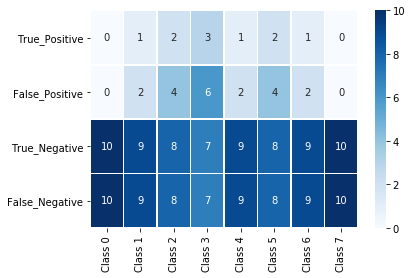

In [13]:
sns.heatmap(d.confusion_matrix_final,cmap = 'Blues', linewidths=0.5, annot=True)

### Accuracy on Validation Data 

In [10]:
print("Holdout Accuracy: " + str(d.confusion_matrix(d.df1)*100))

Holdout Accuracy: 50.0
